### This notebook for week 2 quiz, Logistic regression with regularization
### Will be using numpy and pandas

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string

#### Load Amazon product data

In [97]:
products = pd.read_csv('amazon_baby_subset.csv')

## Print sample data
products.head()


,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1


In [98]:
### Data exploration 
print 'Total number of samples: ', len(products)
print 'Number of positive sample: ', len(products[products['sentiment'] == 1])
print 'Number of negative sample: ', len(products[products['sentiment'] == -1])

Total number of samples:  53072
Number of positive sample:  26579
Number of negative sample:  26493


#### Load important words

In [99]:
important_words = pd.read_json('important_words.json')
important_words = important_words.values.flatten()

#### Perform data cleaning

In [100]:
def remove_punctuation(text):
    text = text.translate(None, string.punctuation)
    return text

In [101]:
sample_text = "This isn't an issue !!!"
print 'Converted text: ', remove_punctuation(sample_text)

Converted text:  This isnt an issue 


In [102]:
### Fill all n/a in review column with empty ("") string
products = products.fillna({'review':''})

### Remove punctuation
products['review_clean'] = products['review'].apply(remove_punctuation)
products.head()

,name,review,rating,sentiment,review_clean
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago S...
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,One of babys first and favorite books and it i...
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,Very cute interactive book My son loves this b...


#### 'Bag of Words' text analysis on review_clean column

In [103]:
for word in important_words:
    #print word
    products[word] = products['review_clean'].apply(lambda s: s.split().count(word))

In [104]:
#### After bag of words analysis for important words
products.head()

,name,review,rating,sentiment,review_clean,baby,one,great,love,use,...,seems,picture,completely,wish,buying,babies,won,tub,almost,either
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago S...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,One of babys first and favorite books and it i...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,Very cute interactive book My son loves this b...,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


### Train-Test splitting

In [105]:
### Load the indicies files
train_indicies = pd.read_json('module-4-assignment-train-idx.json')
val_indicies = pd.read_json('module-4-assignment-validation-idx.json')
train_indicies = train_indicies.values.flatten()
val_indicies = val_indicies.values.flatten()

In [106]:
trainig_set = products.iloc[train_indicies]
validation_set = products.iloc[val_indicies]
print 'Training set size: ', trainig_set.shape
print 'Validation set size: ', validation_set.shape

Training set size:  (42361, 198)
Validation set size:  (10711, 198)


##### Convert data into multidimensional array

In [107]:
def get_numpy_data(dataframe, features, label):
    # Initialize the np array with all ones, the number of columns are +1 
    # to accomodate the column for bias feature
    matrix_len = len(dataframe)
    matrix_width = len(features) + 1
    feature_matrix = np.ones((matrix_len, matrix_width))
    
    print 'Feature matrix size', feature_matrix.shape
    i = 1
    for feature in features:
        feature_matrix[:, i] = dataframe[feature]
        i = i +1
    return (feature_matrix, dataframe[label])

In [108]:
## Extract the training and validation data
training_data, train_output = get_numpy_data(trainig_set, important_words, 'sentiment')
validation_data, validation_output = get_numpy_data(validation_set, important_words, 'sentiment')

Feature matrix size (42361, 194)
Feature matrix size (10711, 194)


In [109]:
def predict_probability(feature_matrix, coefficients):
    return (1.0 / (1 + np.exp(-1 * np.dot(feature_matrix, coefficients))))

In [110]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant):
    #print feature
    derivative = np.dot(feature, errors)
    
    if feature_is_constant == True:
        derivative = derivative
    else:
        derivative = derivative - 2 * (l2_penalty * coefficient)
        
    return derivative;

The log-likelihood is computed using the following formula (see the advanced optional video if you are curious about the derivation of this equation):

ℓℓ(w)=∑i=1N((1[yi=+1]−1)w⊺h(wi)−ln(1+exp(−w⊺h(xi))))


In [111]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1).values.reshape(-1,1)
    scores = np.dot(feature_matrix, coefficients)
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores)))
    lp = lp - l2_penalty * (coefficients**2).sum()
    return lp

In [112]:
from math import sqrt
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients)
    itr = 0;
    while (itr < max_iter):
        predictions = predict_probability(feature_matrix, coefficients)
        indicator = (sentiment==+1).values.reshape(-1,1)
        
        #print 'indicator shape', indicator.shape
        #print 'predictions shape', predictions.shape
        
        error = indicator - predictions

        for i in xrange(len(coefficients)):
            if i == 0:
                derivative = feature_derivative_with_L2(error, feature_matrix[:,i], coefficients[i], l2_penalty, True)
            else:
                derivative = feature_derivative_with_L2(error, feature_matrix[:,i], coefficients[i], l2_penalty, False)
            
            coefficients[i] = coefficients[i] + step_size * derivative
    
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print 'iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp)
       
        itr = itr +1
    return coefficients

In [113]:
initial_coefficients = np.zeros((training_data.shape[1], 1))
print initial_coefficients.shape
step_size = 5e-6
max_iter = 501

(194, 1)


In [114]:
l2_penalties = [0, 4, 10, 1e2, 1e3, 1e5]
coefficients = []
for l2_penalty in l2_penalties:
    print 'Running with L2 Penalty: ', l2_penalty
    coefficient = logistic_regression_with_L2(training_data, train_output, initial_coefficients, step_size, l2_penalty, max_iter)
    coefficients.append(coefficient)

Running with L2 Penalty:  0
iteration   0: log likelihood of observed labels = -29179.39138303
iteration   1: log likelihood of observed labels = -29003.71259047
iteration   2: log likelihood of observed labels = -28834.66187288
iteration   3: log likelihood of observed labels = -28671.70781507
iteration   4: log likelihood of observed labels = -28514.43078198
iteration   5: log likelihood of observed labels = -28362.48344665
iteration   6: log likelihood of observed labels = -28215.56713122
iteration   7: log likelihood of observed labels = -28073.41743783
iteration   8: log likelihood of observed labels = -27935.79536396
iteration   9: log likelihood of observed labels = -27802.48168669
iteration  10: log likelihood of observed labels = -27673.27331484
iteration  11: log likelihood of observed labels = -27547.98083656
iteration  12: log likelihood of observed labels = -27426.42679977
iteration  13: log likelihood of observed labels = -27308.44444728
iteration  14: log likelihood of o

iteration  10: log likelihood of observed labels = -27831.24093409
iteration  11: log likelihood of observed labels = -27731.70850491
iteration  12: log likelihood of observed labels = -27637.10940782
iteration  13: log likelihood of observed labels = -27547.15928610
iteration  14: log likelihood of observed labels = -27461.59305444
iteration  15: log likelihood of observed labels = -27380.16329573
iteration  20: log likelihood of observed labels = -27027.47302631
iteration  30: log likelihood of observed labels = -26527.67369887
iteration  40: log likelihood of observed labels = -26207.10815677
iteration  50: log likelihood of observed labels = -25996.48934850
iteration  60: log likelihood of observed labels = -25855.43709251
iteration  70: log likelihood of observed labels = -25759.49953854
iteration  80: log likelihood of observed labels = -25693.40742351
iteration  90: log likelihood of observed labels = -25647.38445043
iteration 100: log likelihood of observed labels = -25615.0414

In [134]:
### Create table 
coefficients_wo_intercept = np.array(coefficients).reshape(len(l2_penalties), len(important_words) + 1)[:,1:]
#coefficients_wo_intercept = np.array(coefficients_wo_intercept).reshape(5, 194)
coefficients_wo_intercept = coefficients_wo_intercept.transpose()
coefficients_wo_intercept.shape
#coefficients_wo_intercept

(193, 6)

In [163]:
coefficients_l2_0 = list(coefficients[0][1:].flatten()) # exclude intercept
coff_word_tuples = [(word, coff) for coff, word in zip(coefficients_l2_0, important_words)]
coff_word_tuples = sorted(coff_word_tuples, key=lambda x:x[1], reverse=True)
coff_word_tuples

[(u'love', 1.0585539820695435),
 (u'loves', 1.0524840477983537),
 (u'easy', 0.98455881987319227),
 (u'perfect', 0.83569320763834631),
 (u'great', 0.80162498977817642),
 (u'happy', 0.55739520236344631),
 (u'best', 0.53503388977177702),
 (u'little', 0.5244194563643344),
 (u'fits', 0.48765225326529715),
 (u'well', 0.45386648676755048),
 (u'nice', 0.42939368687365687),
 (u'soft', 0.36178253568480429),
 (u'recommend', 0.35830984214048356),
 (u'works', 0.33915488485635242),
 (u'bit', 0.33575799826001018),
 (u'comfortable', 0.33359187604435814),
 (u'without', 0.26853378635835035),
 (u'price', 0.26579742591233047),
 (u'daughter', 0.26341775986429966),
 (u'room', 0.26031990321424064),
 (u'lot', 0.2460909012187312),
 (u'need', 0.22630398111418579),
 (u'old', 0.20891243361852321),
 (u'night', 0.20687913115053969),
 (u'kids', 0.19940875080594056),
 (u'car', 0.19336369437756273),
 (u'still', 0.18850824654810061),
 (u'size', 0.18149720783033321),
 (u'play', 0.17960239584526183),
 (u'set', 0.17427863

##### Top 5 important words in L2 = 0

In [168]:
print coff_word_tuples[0:5]
positive_words = np.array(coff_word_tuples[0:5])
positive_words= positive_words[:,0]
#print important_words
index_pw = np.where(np.in1d(important_words, positive_words))[0]
print index_pw

[(u'love', 1.0585539820695435), (u'loves', 1.0524840477983537), (u'easy', 0.98455881987319227), (u'perfect', 0.83569320763834631), (u'great', 0.80162498977817642)]
[ 2  3  7 22 33]


#### Bottom 5 words

In [169]:
print coff_word_tuples[-5:]
negative_words = np.array(coff_word_tuples[-5:])
negative_words= negative_words[:,0]
#print important_words
index_nw = np.where(np.in1d(important_words, negative_words))[0]
print index_nw

[(u'returned', -0.57270704515811255), (u'waste', -0.6178091779812257), (u'return', -0.74208495463503965), (u'money', -0.7687931346121053), (u'disappointed', -0.95543662817072728)]
[ 96 105 112 113 168]


In [170]:
#Select the rows with positive words
positive_w_coef = coefficients_wo_intercept[index_pw,:]
positive_w_coef

array([[ 0.80162499,  0.79689693,  0.78993515,  0.70142507,  0.37601171,
         0.00894956],
       [ 1.05855398,  1.05085568,  1.03952852,  0.89664413,  0.41835364,
         0.00904174],
       [ 0.98455882,  0.97760015,  0.96736184,  0.83824483,  0.40190397,
         0.00880768],
       [ 1.05248405,  1.04390291,  1.03126535,  0.87079397,  0.34587026,
         0.00614988],
       [ 0.83569321,  0.82855467,  0.81803784,  0.68414294,  0.25061384,
         0.0039888 ]])

In [171]:
#Select the rows with negative words
negative_w_coef = coefficients_wo_intercept[index_nw,:]
negative_w_coef

array([[-0.76879313, -0.76273398, -0.75381829, -0.64140575, -0.27588337,
        -0.00548721],
       [-0.95543663, -0.94697992, -0.93451842, -0.77562514, -0.26609518,
        -0.0040134 ],
       [-0.61780918, -0.61247451, -0.60462025, -0.50518876, -0.19063065,
        -0.0033449 ],
       [-0.74208495, -0.7355024 , -0.72580657, -0.60264636, -0.21519852,
        -0.00372969],
       [-0.57270705, -0.56751849, -0.55986985, -0.46205568, -0.15002095,
        -0.00222464]])

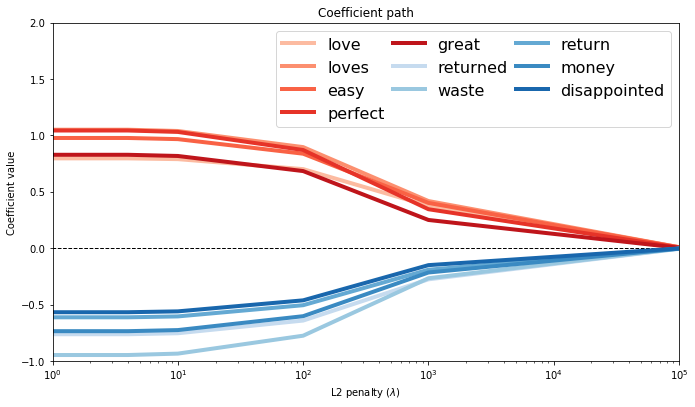

In [172]:

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, positive_w_coef, negative_w_coef, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = positive_w_coef
    table_negative_words = negative_w_coef

    
    for i in xrange(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i in xrange(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()


make_coefficient_plot(coefficients_wo_intercept, positive_words, negative_words, positive_w_coef, negative_w_coef, l2_penalties)


#### Comparing model with different L2 penalties

In [173]:
def accuracy (coff, feature_matrix, output):
    scores = np.dot(feature_matrix, coff)
    indicies = scores > 0
    indicies_low = scores <= 0
    scores[indicies] = 1
    scores[indicies_low] = -1
    
    miss_classifications =  (abs(scores - output.values.reshape(-1,1))).sum() /2
    correct_classification = len(feature_matrix) - miss_classifications
    total_examples = len(feature_matrix)
    return correct_classification * 1.0 / total_examples

In [174]:
i = 0
for coff in coefficients:
    print "%s : Accuracy on Training / Validation set: %s %s" %(
    l2_penalties[i], 
    accuracy (coff, training_data, train_output),
    accuracy (coff, validation_data, validation_output))
        
    i = i + 1    

0 : Accuracy on Training / Validation set: 0.785156157787 0.78143964149
4 : Accuracy on Training / Validation set: 0.785108944548 0.781533003454
10 : Accuracy on Training / Validation set: 0.784990911452 0.781719727383
100.0 : Accuracy on Training / Validation set: 0.783975826822 0.781066193633
1000.0 : Accuracy on Training / Validation set: 0.775855149784 0.771356549342
100000.0 : Accuracy on Training / Validation set: 0.680366374731 0.667818130893
